<div>
     <div>
        <img src="./report/isel_logo.png" width="400" height="400" align="left">
    </div>
    <div>
        <h2>Área Departamental de Engenharia de Eletrónica e Telecomunicações e de Computadores</h2>
        <p>Trabalho prático 4</p>
        <p>Autor:	44598	André L. A. Q. de Oliveira</p>
        <p>Unidade Curricular Compressão de Sinais Multimédia</p>
        <p>Professor: André Lourenço</p>
        <p>27 - Junho - 2021</p>
    </div>
</div>

### <a id="index"></a>

# Index
- [Compressão](#compressao)
    - [snr](#snr)
- [Entropia](#entropia)
    - [get_symbol_frequency](#get_symbol_frequency)
    - [calculate_entropy](#calculate_entropy)
- [Erro absoluto médio (MAE)](#mae)
- [Utilities](#utilities)
    - [imshow](#imshow)
    - [convertFrame2Jpeg](#convertFrame2Jpeg)
    - [subtract_frame](#createPframe)
    - [reconstruct_Pframe](#reconstruct_Pframe)
    - [to_macro_blocks](#to_macro_blocks)
    - [from_macro_blocks](#from_macro_blocks)
    - [sortDictionaryValuesByDistance](#sortDictionaryValuesByDistance)
    - [BestMatchResult](#BestMatchResult)
    - [window_best_match](#window_best_match)
    - [full_search](#full_search)
    - [get_match_frame](#get_match_frame)
- [Codificador 1](#codificador_1)
    - [encode_1](#encode_1)
    - [decode_1](#decode_1)
- [Codificador 2](#codificador_2)
    - [encode_2](#encode_2)
    - [decode_2](#decode_2)
- [Codificador 3](#codificador_2)
    - [encode_3](#encode_3)
    - [decode_3](#decode_3)
- [Testes](#testes)
    - [Taabelas](#tabelas)
- [Conclusões](#conclusoes)

# Importar bibliotecas

In [183]:
import os
import math
from time import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd() # current work diretory

<a id="compressao"></a>

# Compressão

A taxa de compressão pode ser cáculada atrás da seguinte expressão matemática:

$$ T_c = \frac{D_o}{D_c} $$

<a id="snr"></a>

## SNR

A relação sinal-ruído compara o nível de um sinal desejado com o nível do ruído. Quanto mais alta for a relação sinal-ruído, menor é o efeito do ruído de fundo sobre a detecção ou medição do sinal.

$$ SNR(Db) = 10\log_{10}\left[\frac{\sum_{l}\sum_{c}I_{ap}(l,c)^2}{\sum_{l}\sum_{c}[I_{ap}(l,c)-I_{or}(l,c)]^2}\right] $$

In [184]:
def snr(I_or, I_ap):
    Pxa = np.sum(I_ap.astype('float')**2)
    Pe = np.sum( (I_ap.astype('float') - I_or.astype('float'))**2 )
    return 10 * np.log10(Pxa / Pe)

<a id="entropia"></a>

# Entropia

A entropia mede a quantidade de informação codificada na mensagem, onde quando maior for o valor entrópico, maior será a incerteza.

A entropia da fonte é dada pela seguinte expressão matemática:

$$ H(S) = -\sum_{i=1}^{N}p(s_i)log_{2}p(s_i) $$


A eficiência da condificação pode ser obtida através da seguinte expressão matemática:

$$ \eta = \frac{H(S)}{L} $$

onde, **_L_** é o número médio de bits por símbolo.

É possível codificar uma fonte, sem perdas, se o número médio de bits por símbolo for maior ou igual à entropia da fonte:

$$ H(S) < L < H(S) + \delta $$

<a id="get_symbol_frequency"></a>

## get_symbol_frequency


Lê um ficheiro, símbolo a símbolo, e retorna um dicionário com par chave-valor : símbolo-frequência, onde cada símbolo terá como respondência a sua frequência no ficheiro. 

In [319]:
# return dicionary {symbol : frequency}
def get_symbol_frequency(file):
    d = dict()
    for i in file:
        d[i] = d.setdefault(i, 0) + 1
    return d

<a id="entropy"></a>

## entropy


In [185]:
def calculate_entropy(symbol_freq_dictionary):
    # list of symbol occurences in file
    occurrences = list(symbol_freq_dictionary.values())
    # total number of symbols
    t = np.sum(occurrences)
    # probability of each symbol
    p = [occ / t for occ in occurrences]
    return -np.sum([p * np.log2(p)])

<a id="efficiency"></a>

## efficiency

In [186]:
def efficiency(H, dictionary):
    # average number of bits per symbol
    L = 0
    for symbol in dictionary:
        L += len(dictionary[symbol])
    L = L / len(dictionary)
    return L, ( H / L )

<a id="mae"></a>

# Erro absoluto médio (MAE)

Critério de semelhança entre blocos

$$ (d_m,d_n) = arg \min_{d_m,d_n} \frac{1}{MN}\sum_{m=1}^{M}\sum_{n=1}^{N} \left| X^{t}(m,n)-X^{t-1}(m-d_m,n-d_n) \right| $$

In [187]:
def mae(b1, b2):
    return np.sum(np.abs(cv2.subtract(b1,b2).ravel())) / len(b1.ravel())

In [188]:
block1 = np.ones(256).reshape((16,16))
block2 = (np.ones(256)*3).reshape((16,16))

print(mae(block1, block2))

2.0


[back to index](#index)

<a id="utilities"></a>

# Utilities

<a id="imshow"></a>

## imshow

In [189]:
def imshow(title, image):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

<a id="convertFrame2Jpeg"></a>

## convertFrame2Jpeg

In [190]:
def convertFrame2Jpeg(path, frame):
    cv2.imwrite(f"{path}.jpg", frame, (cv2.IMWRITE_JPEG_QUALITY, 50))
    return cv2.imread(f"{path}.jpg", cv2.IMREAD_GRAYSCALE)

<a id="subtract_frame"></a>

## subtract_frame

In [191]:
def subtract_frame(frame, Iframe):
    return ( ( frame.astype('int16') - Iframe.astype('int16') ) / 2  + 127 ).astype('uint8')

<a id="reconstruct_Iframe"></a>

## reconstruct_Pframe

In [192]:
def reconstruct_Pframe(Sframe, Iframe):
    return ( (Sframe.astype('int16') - 127)*2 + Iframe.astype('int16') ).astype('uint8')

In [247]:
i_f = cv2.imread(f"{cwd}/input_data/bola_seq/bola_1.tiff", cv2.IMREAD_GRAYSCALE)
print("i_f\n", i_f, "\n")

p_f = cv2.imread(f"{cwd}/input_data/bola_seq/bola_2.tiff", cv2.IMREAD_GRAYSCALE)
print("pf\n", p_f, "\n")

s_f = subtract_frame(p_f, i_f)
print("s_f\n", s_f, "\n")

r_f = reconstruct_Pframe(s_f, i_f)
print("r_f\n", r_f, "\n")

i_f
 [[ 60  62  62 ...  30  32  32]
 [ 68  69  75 ...  31  33  32]
 [ 89  57  58 ...  30  33  32]
 ...
 [ 62  63  62 ...  62  55  28]
 [ 62  64  65 ... 120 119  99]
 [ 65  63  64 ... 119 119 119]] 

pf
 [[ 59  60  65 ...  29  31  32]
 [ 69  71  72 ...  29  32  32]
 [ 98  58  55 ...  29  32  33]
 ...
 [ 62  63  63 ...  69  59  36]
 [ 63  63  62 ... 120 121 107]
 [ 64  64  64 ... 119 119 119]] 

s_f
 [[126 126 128 ... 126 126 127]
 [127 128 125 ... 126 126 127]
 [131 127 125 ... 126 126 127]
 ...
 [127 127 127 ... 130 129 131]
 [127 126 125 ... 127 128 131]
 [126 127 127 ... 127 127 127]] 

r_f
 [[ 58  60  64 ...  28  30  32]
 [ 68  71  71 ...  29  31  32]
 [ 97  57  54 ...  28  31  32]
 ...
 [ 62  63  62 ...  68  59  36]
 [ 62  62  61 ... 120 121 107]
 [ 63  63  64 ... 119 119 119]] 



<a id="to_macro_blocks"></a>

### to_macro_blocks

Divide uma imagem em uma matriz de blocos de tamanho size x size.

In [194]:
def to_macro_blocks(image, size):
    
    width, height = image.shape
    
    if (width % size) != 0 or (height % size) != 0:
        raise Exception('function only supports multiple macro block division!')
    
    macro_blocks = np.zeros((int(width/size), int(height/size)), dtype=object)
    
    i = -1
    j = -1
    for lin in range(0, width, size):
        i += 1
        j = -1
        for col in range(0, height, size):
            j += 1
            # create new block
            macro_blocks[i][j] = image[lin:(lin + size),col:(col  +size)]
                
    return macro_blocks

<a id="from_macro_blocks"></a>

### from_macro_blocks

Merge um matriz de macro blocos para uma imagem.

In [195]:
def from_macro_blocks(matrix, size):
    
    width  = matrix.shape[0] * size
    heigth = matrix.shape[1] * size
    
    output = np.zeros((width, heigth), dtype='uint8')
    
    i = -1
    j = -1
    for lin in range(0, width, size):
        i += 1
        j = -1
        for col in range(0, heigth, size):
            j += 1
            output[lin:(lin+size),col:(col+size)] = matrix[i][j]
    return output

In [246]:
f = np.arange(64).reshape((8,8))
print('f\n', f, "\n")

mb = to_macro_blocks(f, 4)
print('divite to blocks\n', mb, "\n")

r_f = from_macro_blocks(mb,4)
print('merge from blocks\n', r_f, "\n")

f
 [[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]] 

divite to blocks
 [[array([[ 0,  1,  2,  3],
         [ 8,  9, 10, 11],
         [16, 17, 18, 19],
         [24, 25, 26, 27]]) array([[ 4,  5,  6,  7],
                                   [12, 13, 14, 15],
                                   [20, 21, 22, 23],
                                   [28, 29, 30, 31]])]
 [array([[32, 33, 34, 35],
         [40, 41, 42, 43],
         [48, 49, 50, 51],
         [56, 57, 58, 59]]) array([[36, 37, 38, 39],
                                   [44, 45, 46, 47],
                                   [52, 53, 54, 55],
                                   [60, 61, 62, 63]])]] 

merge from blocks
 [[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43

[back to index](#index)

<a id="sortDictionaryValuesByDistance"></a>
 
## sortDictionaryValuesByDistance

Ordena um dicionário chave-vale do tipo **dict<(x,y), MAE>**, segundo o critério de próximidade pelo parâmetro de entrada **coord**.

Tem como objetivo, após ordenação, caso existam valores idênticos de erro absoluto médio para várias entradas do dicionário, que estas estejas ordenadas pela próximidade (distância mais curta) de uma dada coordenada.

In [197]:
def sortDictionaryValuesByDistance(d: dict, coord):
    return dict(sorted(d.items(), key=lambda item: math.sqrt((coord[0]-item[0][0])**2+(coord[1]-item[0][1])**2)))

In [198]:
d = dict()
d[(0,0)] = 3
d[(0,1)] = 7
d[(0,4)] = 6
d[(0,3)] = 2
d[(1,1)] = 2

print(d)
d = sortDictionaryValuesByDistance(d, (1,3) )
print(d)

best_key = min(d, key=d.get)
print(best_key)

{(0, 0): 3, (0, 1): 7, (0, 4): 6, (0, 3): 2, (1, 1): 2}
{(0, 3): 2, (0, 4): 6, (1, 1): 2, (0, 1): 7, (0, 0): 3}
(0, 3)


<a id="BestMatchResult"></a>
 
## BestMatchResult

Classe que serve para agrupar vários tipos de informação do resultado da estratégia de procura exaustiva.
* **from_coord:** a coordenada original do canto superior esquerdo do bloco
* **macro_block:** o bloco  
* **to_coord:** a coordenada da nova posição do bloco, para calcular o vetor de movimento
* **match_block:** o bloco resultante do match com o melhor resultado do erro méido absoluto

In [199]:
class BestMatchResult(object): 
    def __init__(self, from_coord, macro_block, to_coord, match_block):
        self.from_coord = from_coord
        self.macro_block = macro_block
        self.to_coord = to_coord
        self.match_block = match_block

    def get_from_coord(self):
        return self.from_coord
    def get_macro_block(self):
        return self.macro_block 
    def get_to_coord(self):
        return self.to_coord
    def get_match_block(self):
        return self.match_block

<a id="window_best_match"></a>
 
## window_best_match

Para cada macro bloco de Iframe, vai procurar numa janela de dimensões(x1,y1)(x2,y2) na frame **Pframe** pelo vetor de movimento resultante da melhor match.

In [200]:
def window_best_match(macroBlock, frame, coord, x1, y1, x2, y2):
    # creates a dictionary to store coord(x,y), mae value
    d = dict()
    for i in range(x1, x2 + 1): # until
        for j in range(y1, y2 + 1):
            d[i,j] = mae(frame[i:(i+macroBlock.shape[0]), j:(j+macroBlock.shape[1])], macroBlock)
            
    dByDistance = sortDictionaryValuesByDistance(d, coord)
    best_key = min(dByDistance, key=d.get)
    matchBlock = frame[best_key[0]:(best_key[0]+macroBlock.shape[0]), best_key[1]:(best_key[1]+macroBlock.shape[1])]
    return BestMatchResult( coord, macroBlock, best_key, matchBlock )  

In [201]:
if3 = [[ 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0],
       [ 1, 1, 1, 0, 0, 0],
       [ 1, 1, 1, 0, 0, 0],
       [ 1, 1, 1, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0]]
if3 = np.array(if3)

# pframe
pf3 = [[ 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0],
       [ 0, 1, 1, 1, 0, 0],
       [ 0, 1, 1, 1, 0, 0],
       [ 0, 1, 1, 1, 0, 0]]

pf3 = np.array(pf3)
mb = to_macro_blocks(pf3, 2)
print('macro-blocks\n', mb, "\n")
print('macro-blocks[1,1]\n', mb[1,1], "\n")

best_match = window_best_match(mb[1,1], if3, (2,2), 2-2, 2-2, 2+2, 2)
print('best_match-from_coord: ', best_match.get_from_coord(), "\n")
print('best_match-macro_block\n', best_match.get_macro_block(), "\n")
print('best_match-to_coord: ', best_match.get_to_coord(), "\n")
print('best_match-match_block\n', best_match.get_match_block(), "\n")

macro-blocks
 [[array([[0, 0],
         [0, 0]]) array([[0, 0],
                         [0, 0]]) array([[0, 0],
                                         [0, 0]])]
 [array([[0, 0],
         [0, 1]]) array([[0, 0],
                         [1, 1]]) array([[0, 0],
                                         [0, 0]])]
 [array([[0, 1],
         [0, 1]]) array([[1, 1],
                         [1, 1]]) array([[0, 0],
                                         [0, 0]])]] 

macro-blocks[1,1]
 [[0 0]
 [1 1]] 

best_match-from_coord:  (2, 2) 

best_match-macro_block
 [[0 0]
 [1 1]] 

best_match-to_coord:  (1, 1) 

best_match-match_block
 [[0 0]
 [1 1]] 



<a id="full_search"></a>
 
## full_search

Executa uma estratégia de procura exaustiva (FSM). Dada uma janela de procura de dimensões (M x N) irá:
* percorrer todos os blocos
* número de cálculos = (2*p + 1)^2
* cada cálculo = 2(M x N)

In [202]:
def full_search(macroBlocks, Pframe, bs, ws):
    
    #best_match = []
    best_match = np.empty(macroBlocks.shape, dtype=object)
    
    # full-search
    for i in range(macroBlocks.shape[0]):
        for j in range(macroBlocks.shape[1]):
                
            # width
            w = i * bs
            # height
            h = j * bs

            ### bounderies
            # top
            if i == 0:
                # left corner
                if j == 0:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w, j, w+ws, h+ws)
                # right corner
                elif j == (macroBlocks.shape[1] - 1):
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w, h-ws, w, h)
                # center
                else:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w, h-ws, w+ws, h+ws)
            # bottom
            elif i == (macroBlocks.shape[0] - 1):
                # left corner
                if j == 0:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w-ws, h, w, h+ws)
                # right corner - eob
                elif j == (macroBlocks.shape[1] - 1):
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h),  w-ws, h-ws, w, h)
                # center
                else:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w-ws, h-ws, w, h+ws)
            # left
            elif j == 0:
                best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w-ws, h, w+ws, h+ws)
            # right
            elif j == (macroBlocks.shape[1] - 1):
                best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w-ws, h-ws, w+ws, h)
            # center
            else:
                best_match[i,j] = window_best_match(macroBlocks[i,j], Pframe, (w, h), w-ws, h-ws, w+ws, h+ws)
                    
    return best_match

In [203]:
bm = full_search(mb, if3, 2, 2)
for i in range(bm.shape[0]):
    for j in range(bm.shape[1]):
        print('best_match-from_coord: ', bm[i,j].get_from_coord(), "\n")
        print('best_match-macro_block\n', bm[i,j].get_macro_block(), "\n")
        print('best_match-to_coord: ', bm[i,j].get_to_coord(), "\n")
        print('best_match-match_block\n', bm[i,j].get_match_block(), "\n")
        print('--------------------------------------------\n')

best_match-from_coord:  (0, 0) 

best_match-macro_block
 [[0 0]
 [0 0]] 

best_match-to_coord:  (0, 0) 

best_match-match_block
 [[0 0]
 [0 0]] 

--------------------------------------------

best_match-from_coord:  (0, 2) 

best_match-macro_block
 [[0 0]
 [0 0]] 

best_match-to_coord:  (0, 2) 

best_match-match_block
 [[0 0]
 [0 0]] 

--------------------------------------------

best_match-from_coord:  (0, 4) 

best_match-macro_block
 [[0 0]
 [0 0]] 

best_match-to_coord:  (0, 4) 

best_match-match_block
 [[0 0]
 [0 0]] 

--------------------------------------------

best_match-from_coord:  (2, 0) 

best_match-macro_block
 [[0 0]
 [0 1]] 

best_match-to_coord:  (1, 0) 

best_match-match_block
 [[0 0]
 [1 1]] 

--------------------------------------------

best_match-from_coord:  (2, 2) 

best_match-macro_block
 [[0 0]
 [1 1]] 

best_match-to_coord:  (1, 1) 

best_match-match_block
 [[0 0]
 [1 1]] 

--------------------------------------------

best_match-from_coord:  (2, 4) 

best_ma

<a id="get_match_frame"></a>
 
## get_match_frame

In [204]:
def get_match_frame(Iframe, best_full_search_result):
    
    match_blocks = np.zeros(best_full_search_result.shape, dtype=object)
    
    # block size  
    bs = best_full_search_result[0,0].get_macro_block().shape[0]
    
    for i in range(best_full_search_result.shape[0]):
        for j in range(best_full_search_result.shape[1]):
            # move to coordinates
            coord = best_full_search_result[i,j].get_to_coord()
            match_blocks[i,j] = Iframe[coord[0]:coord[0]+bs, coord[1]:coord[1]+bs]
            
    #print(match_blocks)
    
    return from_macro_blocks(match_blocks, bs)

In [205]:
print( get_match_frame(if3, bm) )

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [0 0 1 1 0 0]]


[back to index](#index)

 <a id="codificador_1"></a>
 
# Codificador 1
 
<div class="alert alert-block alert-info">
Considera que cada frame é uma intra-frame (I).
</div>

In [212]:
def encode_1(path, frame):
    return convertFrame2Jpeg(path, frame)

[back to index](#index)

<a id="codificador_2"></a>
 
# Codificador 2
 
<div class="alert alert-block alert-info">
Considera que todas as frames à exceção da primeira (a I-frame) são inter-frames (P), sem compensação de movimento.
</div>

In [218]:
def encode_2(path, Iframe, Pframe):
    return convertFrame2Jpeg(path, subtract_frame(Pframe, Iframe))

In [229]:
def decode_2(path, Iframe, Sframe):
    return convertFrame2Jpeg(path, reconstruct_Pframe(Sframe, Iframe))

[back to index](#index)

<a id="codificador_3"></a>
 
# Codificador 3
 
<div class="alert alert-block alert-info">
Considera que todas as frames à exceção da primeira (a I-frame) são inter-frames (P), com compensação de movimento.
</div>


<a id="encode_3"></a>
 
## encode_3

* para cada macro bloco de cada frame vai-se estimar o vetor de movimento
* é codificado o vector de movimento e a diferença entre a frame no instante actual e a frame estimada para o mesmo instante

![jpeg-encoding](./report/encoder-motion-compensation.png)

In [209]:
def encode_3(path, frames):
    
    # block size
    bs = 16
    # window size
    ws = 15
    
    full_search_result = []
    Sframes = []
    movement_vecor = []
    
    # first frame it's Iframe
    Iframe = frames[0]
    # divide frame i into 16x16 macro blocks
    # macroBlocks = to_macro_blocks(Iframe, bs)
    
    Pframes = frames[1:]
    
    # for each macro block of each Pframe calculate the movement vector 
    for Pframe in Pframes:
        # divide frame p into 16x16 macro blocks
        macroBlocks = to_macro_blocks(Pframe, bs)
        # full_search_result.append( full_search(macroBlocks, Pframe, bs, ws) )
        full_search_result.append( full_search(macroBlocks, Iframe, bs, ws) )
        
    # for each frame calculate the frame with motion compensation
    convertFrame2Jpeg(f"{path}/Iframe_{1}", Iframe)
    for i in range(len(full_search_result)):
        match_frame = get_match_frame(Iframe, full_search_result[i])
        Sframes.append( convertFrame2Jpeg(f"{path}/Sframe_{i+2}", subtract_frame(Pframes[i], match_frame)) )
      
    return Iframe, Sframes, full_search_result

In [238]:
def encode_3(path, Iframe, Pframe):
    
    # block size
    bs = 16
    # window size
    ws = 15
    
    # divide Pframe into 16x16 macro blocks
    macroBlocks = to_macro_blocks(Pframe, bs)
    full_search_result = full_search(macroBlocks, Iframe, bs, ws)
        
    # calculate the frame with motion compensation
    match_frame = get_match_frame(Iframe, full_search_result)
    Sframe = convertFrame2Jpeg(path, subtract_frame(Pframe, match_frame))
      
    return Sframe, full_search_result

<a id="decode_3"></a>

## decode_3

* processo inverso do encode_3.

![jpeg-encoding](./report/decoder-motion-compensation.png)

In [210]:
def decode_3(path, Iframe, Sframes, full_search_result):
    Pframes = []
    for i in range(len(full_search_result)):
        match_frame = get_match_frame(Iframe, full_search_result[i])
        Pframes.append( convertFrame2Jpeg(f"{path}/Pframe_{i+2}", reconstruct_Pframe(Sframes[i], match_frame)) )
    return Iframe, Pframes

In [241]:
def decode_3(path, Iframe, Sframe, full_search_result):
    match_frame = get_match_frame(Iframe, full_search_result)
    return convertFrame2Jpeg(path, reconstruct_Pframe(Sframe, match_frame))

[back to index](#index)

### <a id="testes"></a>

# Testes

In [211]:
error() # cause error to stop here, when execute "run all cells" command

NameError: name 'error' is not defined

## Importar dados

In [326]:
frames = []
frames_size = []
entropy = []

for i in range(len(os.listdir(f"{cwd}/input_data/bola_seq"))):
    frames.append( cv2.imread(f"{cwd}/input_data/bola_seq/bola_{i+1}.tiff", cv2.IMREAD_GRAYSCALE) )
    frames_size.append( os.stat(f"{cwd}/input_data/bola_seq/bola_{i+1}.tiff").st_size )
    entropy.append( calculate_entropy(get_symbol_frequency(frames[i].ravel())) )
    
Iframe = frames[0]
Pframes = frames[1:]

<div class="alert alert-block alert-info">
Codificador 1
</div>

In [288]:
# prepare data with trab4 functions for encode-1
# -- time data
encode_time_1 = []
decode_time_1 = np.empty(len(frames))
decode_time_1[:] = np.nan
# -- compression data
TC_1 = []
SNR_1 = []

# encode
Iframes1 = []

for i in range(len(frames)):
    t_start = time()
    Iframes1.append( encode_1(f"{cwd}/output_data/codificador1/encode/Iframe_{i+1}", frames[i]) )
    t_end = time()
    # --
    encode_time_1.append( (t_end - t_start) )
    # --
    TC_1.append( frames_size[i] / os.stat(f"{cwd}/output_data/codificador1/encode/Iframe_{i+1}.jpg").st_size )
    SNR_1.append( snr(frames[i], Iframes1[i]) )

[back to index](#index)

<div class="alert alert-block alert-info">
Codificador 2
</div>

In [304]:
# prepare data with trab4 functions for encode-2
# -- time data
encode_time_2 = []

# encode
Sframes2 = []

for i in range(len(Pframes)):
    t_start = time()
    Sframes2.append( encode_2(f"{cwd}/output_data/codificador2/encode/Sframe_{i+2}", Iframe, Pframes[i]))
    t_end = time()
    # --
    encode_time_2.append( (t_end - t_start) )

In [305]:
# prepare data with trab4 functions for decode-2
# -- time data
decode_time_2 = []
# -- compression data
TC_2 = []
SNR_2 = []

# decode
Pframes2 = []

for i in range(len(Sframes2)):
    t_start = time()
    Pframes2.append( decode_2(f"{cwd}/output_data/codificador2/decode/Pframe_{i+2}", Iframe, Sframes2[i]))
    t_end = time()
    # --
    decode_time_2.append( (t_end - t_start) )
    # -- 
    TC_2.append( frames_size[i+1] / os.stat(f"{cwd}/output_data/codificador2/decode/Pframe_{i+2}.jpg").st_size )
    SNR_2.append( snr(Pframes[i], Pframes2[i]) )

[back to index](#index)

<div class="alert alert-block alert-info">
Codificador 3
</div>

In [289]:
# prepare data with trab4 functions for encode-3
# -- time data
encode_time_3 = []

# encode
Sframes3 = []
full_search_result = []

for i in range(len(Pframes)):
    t_start = time()
    pf, fsr = encode_3(f"{cwd}/output_data/codificador3/encode/Sframe_{i+2}", Iframe, Pframes[i])
    t_end = time()
    # --
    Sframes3.append( pf )
    full_search_result.append( fsr )
    # --
    encode_time_3.append( (t_end - t_start) )

In [ ]:
# decode
t_start = time()
Iframe3, Pframes3 = decode_3(f"{cwd}/output_data/codificador3/decode", Iframe3, SFrames3, full_search_result)
t_end = time()
# --
decode_time.append( (t_end - t_start) )

In [293]:
# prepare data with trab4 functions for decode-3
# -- time data
decode_time_3 = []
# -- compression data
TC_3 = []
SNR_3 = []

# decode
Pframes3 = []

for i in range(len(Sframes3)):
    t_start = time()
    Pframes3.append( decode_3(f"{cwd}/output_data/codificador3/decode/Pframe_{i+2}", Iframe, Sframes3[i], full_search_result[i]))
    t_end = time()
    # --
    decode_time_3.append( (t_end - t_start) )
    # -- 
    TC_3.append( frames_size[i+1] / os.stat(f"{cwd}/output_data/codificador3/decode/Pframe_{i+2}.jpg").st_size )
    SNR_3.append( snr(Pframes[i], Pframes3[i]) )

[back to index](#index)

<a id="tabelas"></a>

## Tabelas

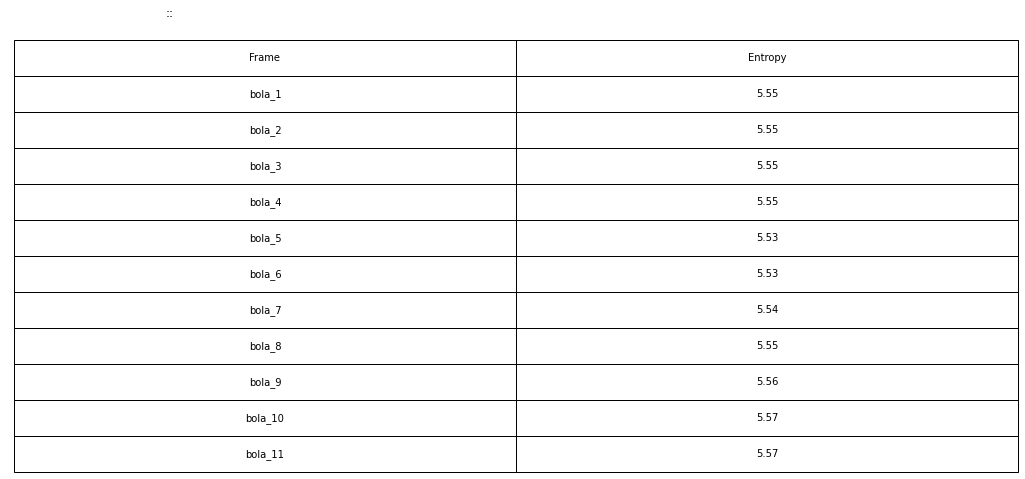

In [332]:
table_header = ['Frame','Entropy']

# table data
table_data_0 = []
for i in range(len(frames)):
    table_data_0.append( 
        [f"bola_{i+1}", 
         round(entropy[i],2)])
        
# create tables
fig0, ax0 = plt.subplots()
        
# build table
table_0 = ax0.table(
    cellText=table_data_0, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')
        
# hide the axes
fig0.patch.set_visible(False)
ax0.axis('off')
ax0.axis('tight')
        
# display table
fig0.suptitle('::')
table_0.scale(3,3)

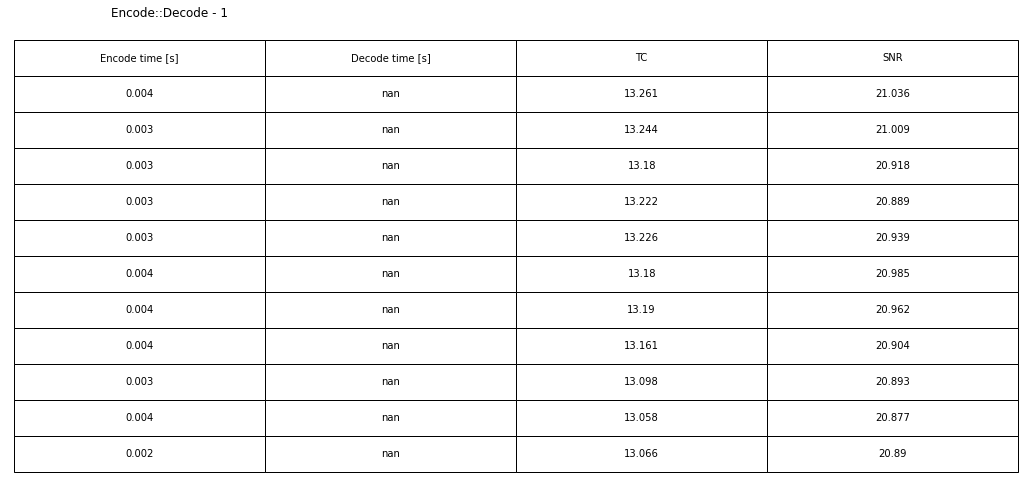

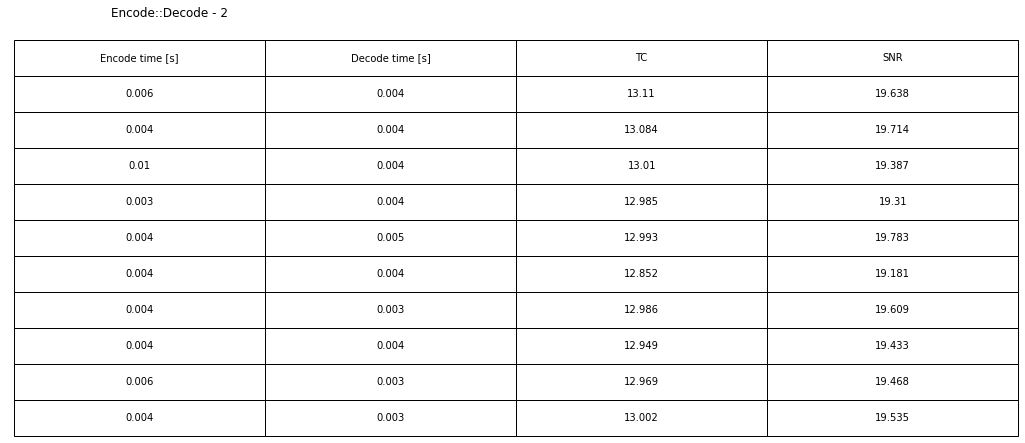

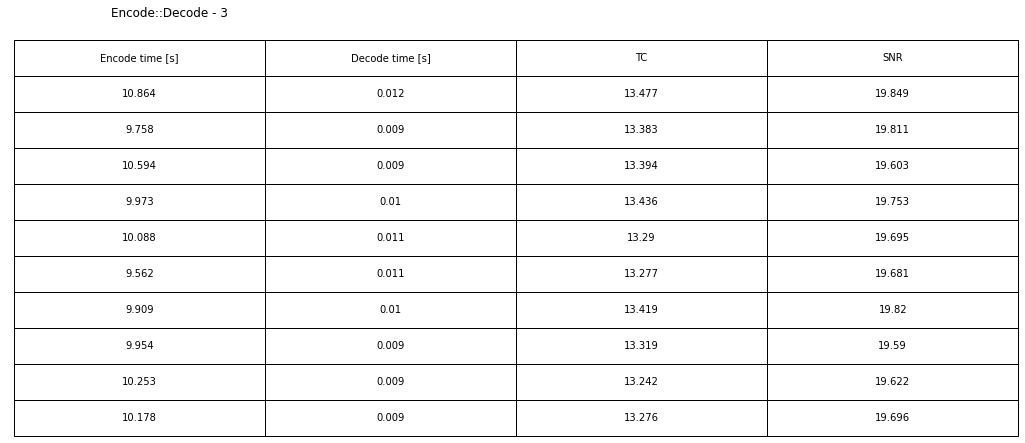

In [330]:
table_header = ['Encode time [s]','Decode time [s]', 'TC', 'SNR']

# table data
table_data_1 = []
for i in range(len(frames)):
    table_data_1.append( 
        [round(encode_time_1[i],3), 
         round(decode_time_1[i],3),
         round(TC_1[i],3),
         round(SNR_1[i],3)])
    
table_data_2 = []
for i in range(len(Pframes2)):
    table_data_2.append( 
        [round(encode_time_2[i],3), 
         round(decode_time_2[i],3),
         round(TC_2[i],3),
         round(SNR_2[i],3)])
    
table_data_3 = []
for i in range(len(Pframes3)):
    table_data_3.append( 
        [round(encode_time_3[i],3), 
         round(decode_time_3[i],3),
         round(TC_3[i],3),
         round(SNR_3[i],3)])

# create tables
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

# build tables
table_1 = ax1.table(
    cellText=table_data_1, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

table_2 = ax2.table(
    cellText=table_data_2, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

table_3 = ax3.table(
    cellText=table_data_3, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

# hide the axes
fig1.patch.set_visible(False)
ax1.axis('off')
ax1.axis('tight')
fig2.patch.set_visible(False)
ax2.axis('off')
ax2.axis('tight')
fig3.patch.set_visible(False)
ax3.axis('off')
ax3.axis('tight')

# display tables
fig1.suptitle('Encode::Decode - 1')
table_1.scale(3,3)
fig2.suptitle('Encode::Decode - 2')
table_2.scale(3,3)
fig3.suptitle('Encode::Decode - 3')
table_3.scale(3,3)

plt.show()

<a id="conclusoes"></a>

# Conclusões

Este trabalho explora os princípios básicos da codificação de vídeo. Neste trabalho pretende-se implementar três formas
de codificação de vídeo. Cada um destes codificadores deve ser testado com a a sequência de imagens disponibilizadas.

- pesquisa exaustiva
- macro blocos vao prever movimento procurando o melhor namtch na iframe
- etc

Se a imagem é bem reconstruída, então a relação sinal ruído é muito alta (potência do sinal > potência do ruído), então têm-se como resultado uma boa resolução de imagem. Em contrapartida a taxa de compressão será mais baixa, pois elas são duas propriedades com proporcionalidade inversa.

Como seria de esperar a codificação com compensação de movimento, é mais lenta devido à complexidade computacional.

[back to index](#index)